### Проект
Используете ваш датасет по кластеризации, либо выбираете новый

    0) Изучаете контекст датасета и придумываете бизнес-цель
    1) Делаете постановку задач на исследование (минимум 2 задачи, 1 под классфификацию/регрессию, 1 под кластеризацию (в крайнем случае делаем допущение что у нас нет Y) , )
    2) Оценка Датасета (pandas/np/statsmodel...)
    3) Подготовка данных
    4) Выполнение исследований ( в том числе с промежуточными итогами, визуализациями)
    5) Итоговые визуализации и выводы
    6) Предложения по развитию вашей работы

Датасет:
 
  - Данные о работе медицинских организаций Москвы с 2021 года по 2023.

Цель:   
    
 - Кластеризовать специальности по структуре успешности записи пациентов, в зависимости величины зон записи пациентов
 - Спрогонзировать спрос на услуги врача в поликлиниках.

  Для анализа выбраны данные о записи к офтальмологу в детские, взрослые смешанные поликлиники и стационары Москвы.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import acf, pacf
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, mean_absolute_error, r2_score

In [2]:
data_ = pd.read_excel(r'/Users/olgahromova/Desktop/УчЕБА/МИСиС ДЗ по Python/dataset_2023-09-06.xlsx')

Очистка данных

In [3]:
data = data_[data_.spec == 'Офтальмология']
data = data.replace({'Not Available': np.nan})

In [185]:
data.columns

Index(['index', 'month', 'mo_id', 'dn_qty', 'attach_qty', 'male_attach_qty',
       'femail_attach_qty', 'spec', 'date', 'slots_qty', 'adm_area', 'mo_name',
       'green', 'yellow', 'red', 'ud', 'demand', 'age_group', 'mo_type'],
      dtype='object')

In [4]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
missing_values_table(data)

Your selected dataframe has 19 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [5]:
data.describe().style.format('{:.1f}')

,index,month,mo_id,dn_qty,attach_qty,male_attach_qty,femail_attach_qty,date,slots_qty,green,yellow,red,ud,demand,age_group
count,43337.0,43337.0,43337.0,43337.0,43337.0,43337.0,43337.0,43337.0,43337.0,43337.0,43337.0,43337.0,43337.0,43337.0,43337.0
mean,220985.9,202242.0,7206413.8,27392.8,134952.9,67577.1,67375.8,20224220.9,146.7,140.9,9.3,14.9,53.1,218.2,1.5
std,127955.5,47.5,4507293.5,25631.1,85713.8,41550.1,45073.8,4746.8,84.1,96.6,19.9,31.4,238.2,265.9,0.5
min,4.0,202101.0,103.0,0.0,27620.0,14044.0,12193.0,20210101.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0
25%,110261.0,202206.0,231.0,7402.0,50562.0,27271.0,23085.0,20220601.0,83.0,69.0,0.0,0.0,0.0,96.0,1.0
50%,220758.0,202210.0,10000307.0,15036.0,128506.0,64792.0,65053.0,20221019.0,138.0,123.0,0.0,0.0,0.0,158.0,1.0
75%,332075.0,202303.0,10000396.0,47705.0,206133.0,102136.0,105049.0,20230313.0,200.0,194.0,9.0,14.0,1.0,250.0,2.0
max,443118.0,202307.0,10311831.0,106092.0,314830.0,176510.0,174902.0,20230731.0,507.0,1056.0,407.0,323.0,3565.0,3791.0,2.0


Разведочный анализ данных 

In [6]:
data.date = pd.to_datetime(data.date, format='%Y%m%d')
# data = data.set_index('date')
data_gr = data.groupby(['date'])[['green',	'yellow',	'red',	'ud',	'demand']].sum()
data_gr

,green,yellow,red,ud,demand
date,,,,,
2021-01-01,520,20,250,0,790
2021-02-01,13841,431,1702,502,16476
2022-01-01,533,167,121,440,1261
2022-01-02,123,68,226,0,417
2022-01-03,409,708,102,0,1219
...,...,...,...,...,...
2023-07-27,13661,644,732,2701,17738
2023-07-28,11780,541,608,2186,15115
2023-07-29,5361,174,264,378,6177


In [7]:
data_gr = data_gr.reset_index()
data_gr

,date,green,yellow,red,ud,demand
0,2021-01-01,520,20,250,0,790
1,2021-02-01,13841,431,1702,502,16476
2,2022-01-01,533,167,121,440,1261
3,2022-01-02,123,68,226,0,417
4,2022-01-03,409,708,102,0,1219
...,...,...,...,...,...,...
574,2023-07-27,13661,644,732,2701,17738
575,2023-07-28,11780,541,608,2186,15115
576,2023-07-29,5361,174,264,378,6177
577,2023-07-30,2820,44,8,10,2882


In [8]:
def num_formater(df, cols_f):
    # formatter = dict(zip(cols, format*len(cols)))
    for c in cols_f.keys():
        df[c] = df[c].map(cols_f[c])
    return df

def plot_graph(df, x_name='date', y_name='demand', title_n='Спрос на офтальмологов', colour_col=None):
    fig = px.line(
        data_frame = df.reset_index(),
        x      = x_name,
        y      = y_name,
        color  = colour_col,
        title  = title_n,
        width  = 800,
        height = 450
    )
    fig.update_layout(
        width  = 1800,
        height = 600,
        margin=dict(l=20, r=20, t=35, b=20),
        legend=dict(
            orientation="h",
            yanchor="top",
            y=1,
            xanchor="left",
            x=0.001
        )
    )
    fig.update_xaxes(rangeslider_visible=True)
    fig.show()
    
def create_corr_plot(series, plot_pacf=False):
    corr_array = pacf(series.dropna(), alpha=0.05) if plot_pacf else acf(series.dropna(), alpha=0.05)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,42])
    fig.update_yaxes(zerolinecolor='#000000')
    
    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title)
    fig.show()
    
def count_metrics(test, predictions):
    metrics = {}
    metrics['mape'] = mean_absolute_percentage_error(test, predictions)
    metrics['mae'] = mean_absolute_error(test, predictions)
    metrics['mse'] = mean_squared_error(test, predictions)
    metrics['R^2'] =  r2_score(test, predictions)
    metrics_= pd.DataFrame(data = metrics.values(), index=metrics.keys(), columns=['model_res'])
    return num_formater(metrics_, {'model_res':r'{:.2f}'.format})

def plot_seasonal_decompose(result:DecomposeResult, dates:pd.Series=None, title:str="Seasonal Decomposition"):
    x_values = dates if dates is not None else np.arange(len(result.observed))
    return (
        make_subplots(
            rows=4,
            cols=1,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.observed, mode="lines", name='Observed'),
            row=1,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.trend, mode="lines", name='Trend'),
            row=2,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.seasonal, mode="lines", name='Seasonal'),
            row=3,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.resid, mode="lines", name='Residual'),
            row=4,
            col=1,
        )
        .update_layout(
            height=900, title=f'<b>{title}</b>', margin={'t':100}, title_x=0.5, showlegend=False
        )
    )

In [9]:
plot_graph(data_gr.sort_values('date'), x_name='date', y_name='demand', title_n='Спрос на офтальмологов')

In [10]:
clean_data = data_gr[data_gr.date>'2022-01-08'].dropna()

Данные на вид имеют полугодовую цикличность.

In [11]:
season_dec = seasonal_decompose(clean_data.demand, model='additive',extrapolate_trend='freq', period=183)
plot_seasonal_decompose(season_dec, season_dec.seasonal.index)

Временной ряд называется «стационарным», если он не имеет тренда, демонстрирует постоянную дисперсию во времени и имеет постоянную структуру автокорреляции во времени.

Один из способов проверить, является ли временной ряд стационарным, — это выполнить расширенный тест Дики-Фуллера , в котором используются следующие нулевая и альтернативная гипотезы:

H 0 : Временной ряд является нестационарным. Другими словами, он имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени.

H A : временной ряд является стационарным.

Если p-значение из теста меньше некоторого уровня значимости (например, α = 0,05), то мы можем отвергнуть нулевую гипотезу и сделать вывод, что временной ряд является стационарным.

In [12]:
from statsmodels. tsa.stattools import adfuller
adfuller(clean_data.demand, regression='ct')

(-3.124813888008772,
 0.10045051535658067,
 14,
 554,
 {'1%': -3.975204749433199,
  '5%': -3.4184446178841346,
  '10%': -3.131730068152563},
 10790.938966392205)

    Статистика теста: -3.124813888008779
    P-значение:  0.10045051535657906

Так как Р > 0,05, ряд не стационарен, необходимо дифференцирование

In [13]:
demand = clean_data.set_index('date').demand
create_corr_plot(demand, plot_pacf=False)
create_corr_plot(demand, plot_pacf=True)

In [14]:
clean_data = clean_data.set_index('date')

In [15]:
from datetime import timedelta
train_st = clean_data.index.min()
train_end = train_st + timedelta(days=555)
test_st = train_end + timedelta(days=1)
test_end = clean_data.index.max()

In [16]:
clean_data.index[0]

Timestamp('2022-01-09 00:00:00')

In [17]:
test_end

Timestamp('2023-07-31 00:00:00')

In [18]:
train = clean_data[
    (clean_data.index>=train_st)
    &(clean_data.index<=train_end)
    ]
test = clean_data[
    (clean_data.index>test_st)
    &(clean_data.index<=test_end)]

display(
    'train', train_st, train_end,
    'test', test_st, test_end,
        )
train = train.demand
test = test.demand

'train'

Timestamp('2022-01-09 00:00:00')

Timestamp('2023-07-18 00:00:00')

'test'

Timestamp('2023-07-19 00:00:00')

Timestamp('2023-07-31 00:00:00')

In [19]:
clean_data['partition'] = np.nan
clean_data.loc[(clean_data.index>=train_st)
    &(clean_data.index<=train_end), 'partition'] = 'train'
clean_data.loc[(clean_data.index>=test_st)
    &(clean_data.index<=test_end), 'partition']= 'test'
clean_data.partition.unique()

array(['train', 'test'], dtype=object)

In [20]:
clean_data[clean_data.partition.isna()]
# clean_data[clean_data.index == clean_data.index.max()]

,green,yellow,red,ud,demand,partition
date,,,,,,


In [21]:
import pmdarima
# настроим поиск параметров на обучающей выборке
parameter_search =pmdarima.auto_arima(
                            train, 
                            start_p = 1, 
                            start_q = 1, 
                            max_p = 7, 
                            max_q = 7, 
                            start_P = 1,
                            max_P=14,
                            start_Q=1, 
                            max_Q=14, 
                            seasonal = True,
                            d = 1, 
                            D = 1, 
                            trace = True, 
                            error_action ='ignore', 
                            suppress_warnings = True,  
                            stepwise = True
                            )
                            
# выведем результат
print(parameter_search.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11532.184, Time=4.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11703.483, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11694.470, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11586.997, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11701.486, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11499.335, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11661.581, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11465.627, Time=0.41 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=11637.183, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=11434.474, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=11591.509, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=11326.152, Time=0.19 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=11453.591, Time=0.10 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=10983.021, Time=0.56 sec
 ARIMA(6,1,0)(0,0,0

In [22]:
import statsmodels.api as sm
def model_fit(train, test, model=sm.tsa.statespace.SARIMAX(
                                        train, 
                                        order = (3, 0, 0), 
                                        seasonal_order = (0, 1, 0, 12))):
    # применим метод fit
    result = model.fit()

    # тестовый прогнозный период начнется с конца обучающего периода
    start = len(train)
    
    # и закончится в конце тестового
    end = start+ len(test) - 1
    predictions = result.predict(start, end)
    assert len(test)==len(predictions), 'Количество тестовых и предсказанных наблюдений не равно'
    display(result.summary())
    
    return predictions

/Users/olgahromova/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/olgahromova/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [23]:
def get_model_res(train, test, df, model=sm.tsa.statespace.SARIMAX(
                                        train, 
                                        order = (3, 0, 0), 
                                        seasonal_order = (0, 1, 0, 12))):
    predictions = model_fit(train, test, model)
    
    predictions_df = pd.DataFrame(predictions).rename(columns={'predicted_mean':'demand'})
    predictions_df = predictions_df.set_index(test.index)
    predictions_df['partition'] = 'predicted_mean'
    pred_df = df.reset_index().append(predictions_df.reset_index())
    plot_graph(pred_df, colour_col='partition', title_n='Предсказание спроса на офтальмологов')
    return [pred_df, predictions]

/Users/olgahromova/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/olgahromova/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [24]:
# models_m = pd.DataFrame()
def get_metrics_df(test, predictions, train_st, train_end, test_st, test_end, mod_type='SARIMAX(3, 0, 0)x(0, 1, 0, 12)'):
    res_arima = count_metrics(test, predictions).T
    res_arima['model_params'] = mod_type

    res_arima['train_st'] =  train_st
    res_arima['train_end'] = train_end
    res_arima['test_st'] = test_st
    res_arima['test_end'] = test_end
    return res_arima

In [25]:
order=(7,1,0)
seasonal_order=(0,0,0, 0)
pred_df, predictions = get_model_res(train, test, clean_data, SARIMAX(
                                    train,
                                    # freq='D',
                                    order=order,
                                    seasonal_order=seasonal_order
                                )
              )


/Users/olgahromova/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/olgahromova/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 demand   No. Observations:                  556
Model:               SARIMAX(7, 1, 0)   Log Likelihood               -5474.593
Date:                Wed, 06 Mar 2024   AIC                          10965.186
Time:                        21:42:18   BIC                          10999.737
Sample:                    01-09-2022   HQIC                         10978.683
                         - 07-18-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5307      0.028    -19.175      0.000      -0.585      -0.476
ar.L2         -0.5493      0.027    -20.307      0.000      -0.602      -0.496
ar.L3         -0.5270      0.031    -16.833      0.000      -0.588      -0.466
ar.L4         -0.5289      0.031    -17.151      0.000      -0.589      -0.468
ar.L5         -0.5132      0.031    -16.798      0.000      -0.573      -0.453
ar.L6         -0.4749      0.029    -16.316      0.000      -0.532      -0.418
ar.L7          0.3323      0.025     13.258      0.000       0.283       0.381
sigma2      2.147e+07   7.65e-10    2.8e+16      0.000    2.15e+07    2.15e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              1375.81
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               1.57   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.8e+31. Standard errors may be unstable.
"""

In [26]:
get_metrics_df(test, predictions, train_st, train_end, test_st, test_end)

,mape,mae,mse,R^2,model_params,train_st,train_end,test_st,test_end
model_res,0.72,5146.62,52420388.94,-0.24,"SARIMAX(3, 0, 0)x(0, 1, 0, 12)",2022-01-09,2023-07-18,2023-07-19,2023-07-31


## Кластеризация

In [27]:
# Кластеризация специальностей
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Выберем необходимые признаки для кластеризации
data_clst = data.groupby(['mo_name'])[['green',	'yellow',	'red',	'ud', 'demand', 'slots_qty']].sum().reset_index()

features = ['demand',	'ud', 'slots_qty']
# Стандартизация данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_clst[features])

# Выбор оптимального количества кластеров
# Это может быть сделано с использованием, например, метода локтя или силуэта
# В данном случае для примера выберем количество кластеров равным 3
n_clusters = 3

# Кластеризация с использованием KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data_clst['cluster'] = kmeans.fit_predict(data_scaled)

# Результаты кластеризации
print(data_clst[['mo_name', 'cluster']])

              mo_name  cluster
0   ГБУЗ ГП № 107 ДЗМ        0
1   ГБУЗ ГП № 109 ДЗМ        0
2    ГБУЗ ГП № 11 ДЗМ        0
3   ГБУЗ ГП № 115 ДЗМ        0
4    ГБУЗ ГП № 12 ДЗМ        0
..                ...      ...
80    ГБУЗ ДЦ № 5 ДЗМ        0
81  ГБУЗ КДП №121 ДЗМ        1
82   ГБУЗ КДЦ № 2 ДЗМ        0
83   ГБУЗ КДЦ № 4 ДЗМ        0
84   ГБУЗ КДЦ № 6 ДЗМ        0

[85 rows x 2 columns]


In [28]:
data.columns

Index(['index', 'month', 'mo_id', 'dn_qty', 'attach_qty', 'male_attach_qty',
       'femail_attach_qty', 'spec', 'date', 'slots_qty', 'adm_area', 'mo_name',
       'green', 'yellow', 'red', 'ud', 'demand', 'age_group', 'mo_type'],
      dtype='object')

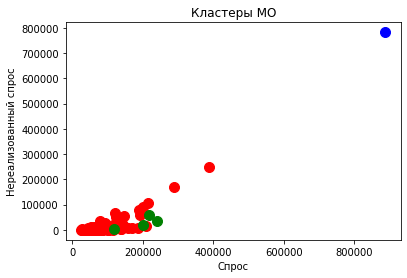

In [29]:
import seaborn as sns
import urbangrammar_graphics as ugg
import matplotlib.pyplot as plt
X =data_clst[['demand', 'ud', 'slots_qty', 'cluster']]
plt.scatter(X[X.cluster==0].demand, X[X.cluster==0].ud, s=100, c='red', label ='Cluster 1')
plt.scatter(X[X.cluster==1].demand, X[X.cluster==1].ud, s=100, c='blue', label ='Cluster 2')
plt.scatter(X[X.cluster==2].demand, X[X.cluster==2].ud, s=100, c='green', label ='Cluster 3')
plt.title('Кластеры МО')
plt.xlabel('Спрос')
plt.ylabel('Нереализованный спрос')
plt.show()

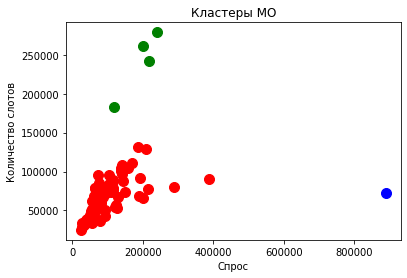

In [30]:
plt.scatter(X[X.cluster==0].demand, X[X.cluster==0].slots_qty, s=100, c='red', label ='Cluster 1')
plt.scatter(X[X.cluster==1].demand, X[X.cluster==1].slots_qty, s=100, c='blue', label ='Cluster 2')
plt.scatter(X[X.cluster==2].demand, X[X.cluster==2].slots_qty, s=100, c='green', label ='Cluster 3')
plt.title('Кластеры МО')
plt.xlabel('Спрос')
plt.ylabel('Количество слотов')
plt.show()

<ipython-input-45-43fdd0dd0319>:30: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



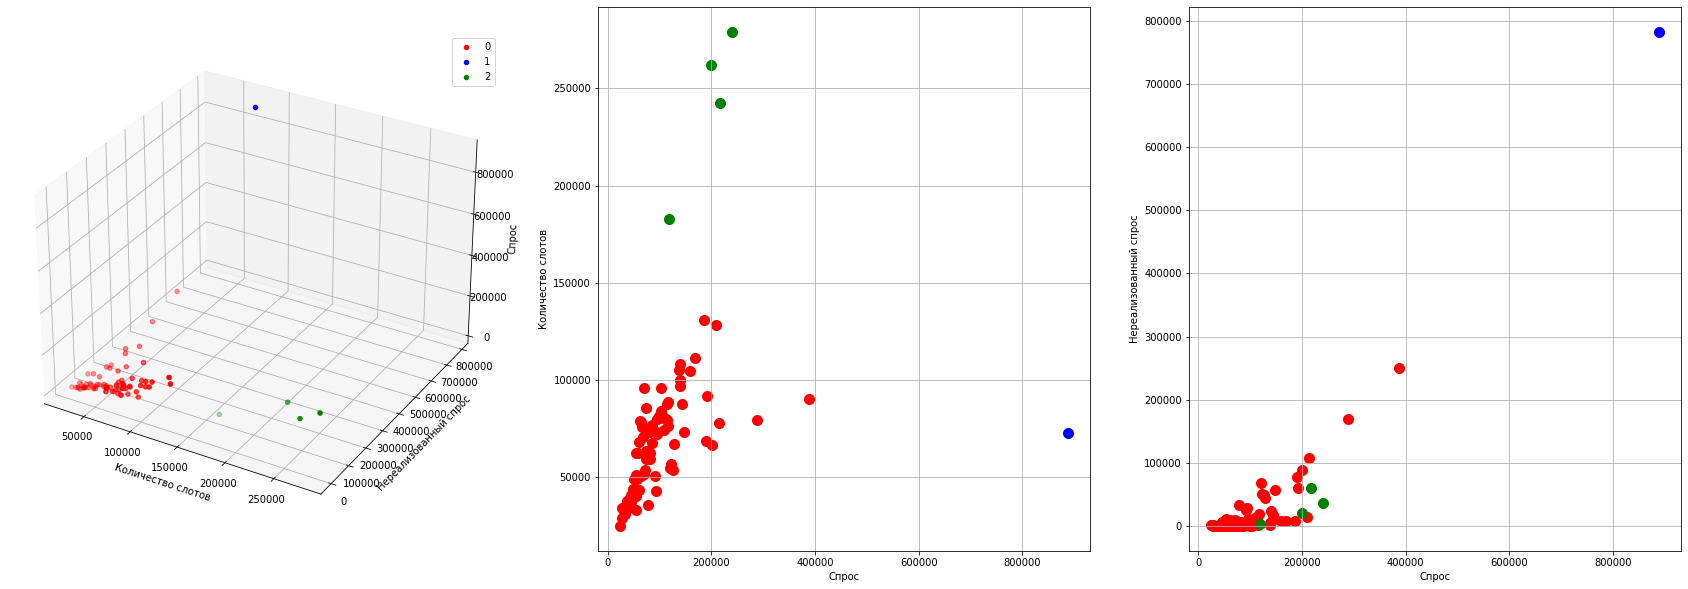

In [45]:
# Создаем трехмерную диаграмму
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(131, projection='3d')

# Разделяем точки по категории и рисуем их с разными цветами
colors = {0: 'red', 1: 'blue', 2:'green'}
for category, group in X.groupby('cluster'):
    ax.scatter(group['slots_qty'], group['ud'], group['demand'], c=colors[category], label=category)
ax.set_xlabel('Количество слотов')
ax.set_ylabel('Нереализованный спрос')
ax.set_zlabel('Спрос')

ax.legend()
ax1 = fig.add_subplot(132)
ax1.scatter(X[X.cluster==0].demand, X[X.cluster==0].slots_qty, s=100, c='red', label ='Cluster 1')
ax1.scatter(X[X.cluster==1].demand, X[X.cluster==1].slots_qty, s=100, c='blue', label ='Cluster 2')
ax1.scatter(X[X.cluster==2].demand, X[X.cluster==2].slots_qty, s=100, c='green', label ='Cluster 3')
ax1.set_xlabel('Спрос')
ax1.grid(visible=True)
ax1.set_ylabel('Количество слотов')

ax2 = fig.add_subplot(133)
ax2.scatter(X[X.cluster==0].demand, X[X.cluster==0].ud, s=100, c='red', label ='Cluster 1')
ax2.scatter(X[X.cluster==1].demand, X[X.cluster==1].ud, s=100, c='blue', label ='Cluster 2')
ax2.scatter(X[X.cluster==2].demand, X[X.cluster==2].ud, s=100, c='green', label ='Cluster 3')
ax2.set_xlabel('Спрос')
ax2.grid(visible=True)
ax2.set_ylabel('Нереализованный спрос')

fig.show()


Таким образом среди медицинских организаций выделилось 3 кластера:
0) Спрос, НС и к-во слотов имеют   